In [1]:
import os 
import pickle
import numpy as np 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import re 
import autogluon as ag
#sys.path.append('/media/nghia/Nguyen NghiaW/RRS-2021/20210322_RRS/RRS/04_RRS/rrs_kit')
from autogluon.tabular import TabularPredictor as task
from sklearn.metrics import (
  accuracy_score,
  f1_score,
  auc,
  roc_curve,
  roc_auc_score,
  precision_score, 
  recall_score,
  precision_recall_curve,
  plot_precision_recall_curve,
  average_precision_score,
  classification_report,
  confusion_matrix,
  precision_recall_fscore_support
)

from rrs_kit.DataClass import DataPath, VarSet
from rrs_kit.utils import plot_ROC_rev, plot_PR_curve
#from rrs_kit.mews import mews_hr, mews_rr, mews_sbp, mews_bt 

from datetime import datetime, timedelta

ImportError: cannot import name 'TabularPrediction' from 'autogluon' (unknown location)

In [8]:

valid_file: str = 'valid_final.pickle'
#type: str = 'mews'
type: str = 'gluon'
#type: str = 'xgb'
scenario: str = 'lab_A'
model_file = type + '_' + scenario + '.pickle' 



In [9]:
# load Path
dp = DataPath()
vs = VarSet()

if type is not 'mews':
  with open(os.path.join(dp.model_path, model_file), 'rb') as f:
    fit = pickle.load(f)

with open(os.path.join(dp.valid_path, valid_file), 'rb') as f:
  df = pickle.load(f)


In [10]:
len(df.Patient.unique())

664

In [11]:
meta_list = ['Age0', 'Gender0']
time_list = ['measurement_time', 'detection_time', 'event_time']
sign_list = [s for s in df.columns for i in vs.vital_grp if i in s ]  

lab_a_list = [s for s in df.columns for i in vs.lab_grp_a if i in s ]
lab_b_list = [s for s in df.columns for i in vs.lab_grp_b if i in s ]
lab_c_list = [s for s in df.columns for i in vs.lab_grp_c if i in s ]
lab_d_list = [s for s in df.columns for i in vs.lab_grp_d if i in s ]
lab_e_list = [s for s in df.columns for i in vs.lab_grp_e if i in s ]
lab_f_list = [s for s in df.columns for i in vs.lab_grp_f if i in s ]

In [12]:
if type == 'mews':
    scenario == 'mews'

if scenario == 'full':
    var_list = [x for x in df.columns.tolist() if x not in ['target', 'Patient']] 
elif scenario == 'sign':
    var_list = meta_list  + sign_list 
elif scenario == 'lab_A':
    var_list = meta_list  + sign_list + lab_a_list 
elif scenario == 'lab_B':
    var_list = meta_list  + sign_list + lab_b_list 
elif scenario == 'lab_C':
    var_list = meta_list  + sign_list + lab_c_list 
elif scenario == 'lab_D':
    var_list = meta_list  + sign_list + lab_d_list 
elif scenario == 'lab_E':
    var_list = meta_list  + sign_list + lab_e_list 
elif scenario == 'lab_F':
    var_list = meta_list  + sign_list + lab_f_list 
elif scenario == 'lab_AB':
    var_list = meta_list  + sign_list + lab_a_list + lab_b_list 
elif scenario == 'lab_ABC':
    var_list = meta_list  + sign_list + \
    lab_a_list + lab_b_list + lab_c_list 
elif scenario == 'lab_ABCD':
    var_list = meta_list + sign_list + \
    lab_a_list + lab_b_list + \
    lab_c_list + lab_d_list 


In [13]:
id = df['Patient'].copy()
measurement_time = df['measurement_time'].copy()
detection_time = df['detection_time'].copy()
event_time = df['event_time'].copy()

if type is not 'mews': 
    label_column = 'target'

    df_fit = df[var_list + [label_column]].copy() 
    df_fit[df_fit == np.inf] = np.nan
    #df['Patient'] = np.nan

    #df.columns.tolist()
    valid_data = task.Dataset(df_fit) 
    X_test = valid_data.drop([label_column], axis = 1).values
    y_test = valid_data[label_column].values

    y_pred = fit.predict(valid_data)
    y_prob = fit.predict_proba(valid_data)

elif type == 'mews':
    # Calculate MEWS score 
    y_prob = df['HR0'].apply(lambda x: mews_hr(x)) + \
     df['RR0'].apply(lambda x: mews_rr(x)) + \
       df['BT0'].apply(lambda x: mews_bt(x)) + \
         df['SBP0'].apply(lambda x:mews_sbp(x))

    y_pred = (y_prob >= 5).astype(int)
    y_prob = [ x / 10. for x in y_prob ]
    
    y_test = df['target'].values


Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [14]:
# predict per a patients 
#threshold = 0.5
#y_pred[y_prob > threshold] = 1 

test = {
    'id': id,
    'true': y_test.astype(int), 
    'score': y_prob,
    'prediction': y_pred,
    'measurement_time': measurement_time,
    'detection_time': detection_time,
    'event_time': event_time 
}



In [16]:
df_test.true.value_counts()

0    23369
1     1213
Name: true, dtype: int64

In [15]:
# Rule 1. detection within 24 hours 
df_test = pd.DataFrame(test)
df_test
#(df_test.true == df_test.prediction).sum()
#id_except = ['ABG1W8Y6', 'O6QQTYQM', 'P9D6C9XJ']


,id,true,score,prediction,measurement_time,detection_time,event_time
0,ABG1W8Y6,1,0.006667,0,2009-09-28 12:00:00,2009-09-28 06:00:00,2009-09-28 21:00:00
1,B6C79PUT,0,0.026667,0,2012-06-07 15:00:00,2012-07-04 22:00:00,2012-07-05 22:00:00
2,B6C79PUT,0,0.023333,0,2012-06-07 16:00:00,2012-07-04 22:00:00,2012-07-05 22:00:00
3,B6C79PUT,0,0.020000,0,2012-06-07 17:00:00,2012-07-04 22:00:00,2012-07-05 22:00:00
4,B6C79PUT,0,0.023333,0,2012-06-07 18:00:00,2012-07-04 22:00:00,2012-07-05 22:00:00
...,...,...,...,...,...,...,...
24577,ZYEBEIQI,0,0.000000,0,2014-06-17 12:00:00,NaT,NaT
24578,ZYEBEIQI,0,0.000000,0,2014-06-17 13:00:00,NaT,NaT
24579,ZYEBEIQI,0,0.000000,0,2014-06-17 13:00:00,NaT,NaT
24580,ZYEBEIQI,0,0.000000,0,2014-06-17 13:00:00,NaT,NaT


In [17]:
def get_score_time(y_true: int, y_pred: int):
    if y_true == y_pred:
        return 1
    else: 
        return 0

In [18]:
def filter_obs_times(m_time, e_time, day = 1, hour = 0):
    if e_time == pd.NaT:
        return 0
    elif m_time >= e_time - timedelta(days = day, hours = hour):
        return 1 
    else: 
        return 0

In [19]:
# filter group rules
res = df_test.copy() 
res['filter_obs'] = res.apply(lambda x: filter_obs_times(
    m_time = x['measurement_time'], 
    e_time = x['event_time'],
    day = 0, 
    hour = 12),
    axis = 1
)

In [21]:
#res = res[res['filter_obs'] == True]
patient_res = res.groupby('id').apply(lambda x: any(x['true'] == x['prediction']))
patient_res = patient_res.reset_index().rename(columns = {
    0: 'res'
}) 
#res


In [26]:
def post_res(y_true,y_pred, res):
    if res == True:
        return y_true
    else:
        return y_pred 

In [27]:
res = res.groupby('id').max() #quantile(.8) #median() #tail(1)
res.true[res['true'] >= 0.5] = 1
res.true[res['true'] < 0.5] = 0

res = pd.merge(left = res, right = patient_res, how = 'left', left_on = 'id', right_on = 'id')
res['y_pred'] = res.apply(lambda x: post_res(
    y_true = x['true'],
    y_pred = x['prediction'],
    res = x['res']),
    axis = 1
    )

In [28]:
res.true.value_counts()

0    607
1     57
Name: true, dtype: int64

In [60]:
y_test = res['true'].tolist()
y_pred = res['y_pred'].tolist()
y_prob = res['score'].round(4).tolist()

#print(y_test)
#print(y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp +fn)
specificity = tn / (tn + fp)


#print('predicted patients: \n', res['id'][res['prediction'] == 1].tolist() )

print([tn, fp, fn, tp])
print('accuracy: ', accuracy_score(y_test, y_pred).round(4))
print('f1: ', f1_score(y_test, y_pred).round(4))
print('precision: ', precision_score(y_test, y_pred).round(4))
print('recall: ', recall_score(y_test, y_pred).round(4))
print('sensitivity: ', sensitivity.round(4))
print('specificity: ', specificity.round(4))
print('AUROC:', roc_auc_score(y_test, y_pred).round(4))
#classification_report(t_test, y_pred)
#plot_ROC_rev(y_test, y_pred)



[607, 0, 24, 33]
accuracy:  0.9639
f1:  0.7333
precision:  1.0
recall:  0.5789
sensitivity:  0.5789
specificity:  1.0
AUROC: 0.7895


In [61]:
fpr, tpr, thrs = roc_curve(y_test, y_prob)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       607
           1       1.00      0.58      0.73        57

    accuracy                           0.96       664
   macro avg       0.98      0.79      0.86       664
weighted avg       0.97      0.96      0.96       664



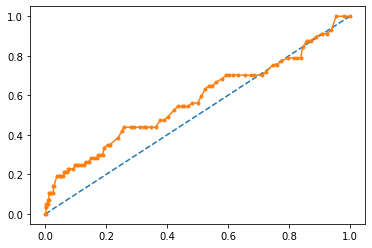

In [63]:
from matplotlib import pyplot
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

pyplot.plot(fpr, tpr, marker='.', label='Proposed_method')

AUPRC: 0.7217


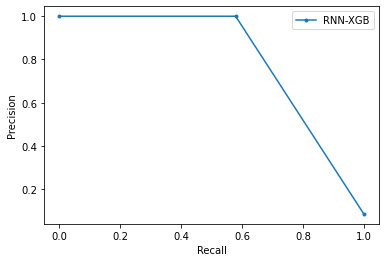

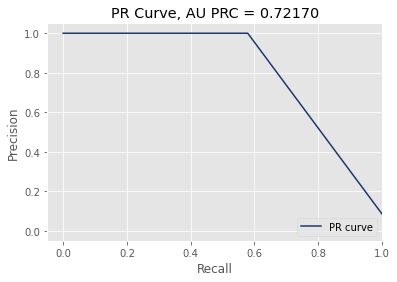

In [64]:
prs, rcs, thrs = precision_recall_curve(y_test, y_pred)
print('AUPRC:', auc(prs, rcs).round(4))
plot_PR_curve(y_test, y_pred)


In [65]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.96196513, 1.        ]),
 array([1.        , 0.57894737]),
 array([0.98061389, 0.73333333]),
 array([607,  57]))